In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, firwin
from scipy import signal

def extraer_datos(data):
    # Abrir el archivo de texto
    with open(data, "r") as f:
        # Saltar las tres primeras líneas
        next(f)
        next(f)
        next(f)
        
        # Leer todas las líneas restantes
        all_data = f.readlines()   
    
    # Procesar cada línea, dividiendo por tabulaciones
    all_data = [line.strip().split('\t') for line in all_data]
    
    # Extraer la primera columna (muestra)
    sample = [int(row[0]) for row in all_data]  # Primera columna

    # Crear una secuencia de números para la muestra (opcional, según tu lógica)
    sample = np.arange(0, len(sample))  # Reemplaza los valores por una secuencia 0, 1, 2, ..., n
    
    # Extraer la sexta columna (amplitud)
    amplitude = [int(row[5]) for row in all_data]  # Sexta columna (índice 5)
    amplitude = np.array(amplitude)
    return sample, amplitude  # Devolver los valores de la muestra y amplitud

def fourier(signal):
    T=1/1000
    frequencies = np.fft.fftfreq(len(signal[:]), T)
    signal_fft = np.fft.fft(signal[:])
    # Solo tomamos la parte positiva de la transformada
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_signal_fft = np.abs(signal_fft[:len(signal_fft)//2])
    return positive_frequencies, positive_signal_fft

def grafica(sample, amplitude):
    plt.figure(figsize=(12, 5))

    # Gráfico de la señal y su transformada
    plt.subplot(1, 2, 1)
    plt.plot(sample/1000, amplitude)
    plt.title('Señal Base')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')

    f, signalFFT = fourier(amplitude)
    plt.subplot(1, 2, 2)
    plt.plot(f, signalFFT)
    plt.ylim(min(signalFFT), max(signalFFT))
    plt.title('Transformada de Fourier')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Amplitud')
    
    plt.tight_layout()
    plt.show()

def zplane(b, a):
    plt.figure(figsize=(6, 6))

    # Normalización de los coeficientes si a[0] no es 1
    if len(a) != 1:
        b = b / a[0]
        a = a / a[0]
    
    # Polos y ceros
    zeros = np.roots(b)
    poles = np.roots(a)

    # Crear el círculo unitario
    unit_circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='dotted')
    plt.gca().add_artist(unit_circle)

    # Graficar los ceros y polos
    plt.plot(np.real(zeros), np.imag(zeros), 'go', label='Ceros')
    plt.plot(np.real(poles), np.imag(poles), 'rx', label='Polos')

    plt.axvline(0, color='k', linestyle='dotted')
    plt.axhline(0, color='k', linestyle='dotted')

    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.title('Diagrama de Polos y Ceros')
    plt.legend()

    plt.grid(True)
    plt.axis('equal')
    plt.show()

def spectrogram(x, fs):
    f, t, Zxx = signal.stft(x, fs, nperseg=100)
    Zxx = 20*np.log10(Zxx)

    # Graficar el espectrograma
    plt.figure(figsize=(15, 6))
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.title('Espectrograma de la STFT')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.ylim(0, 70)
    plt.colorbar(label='Magnitud')
    plt.show()    

def BODE(b, a, fs):
    w, H = signal.freqz(b, a, worN=8000) #w es el vector de frecuencias, H es la funcion como tal

    # Graficar diagrama de Bode
    plt.figure(figsize=(10, 6))

    # Magnitud
    plt.subplot(2, 1, 1)
    plt.plot(0.5 * fs * w / np.pi, 20 * np.log10(np.abs(H)))
    plt.title('Diagrama de Bode')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Magnitud [dB]')
    plt.grid()

    # Fase
    plt.subplot(2, 1, 2)
    plt.plot(0.5 * fs * w / np.pi, np.angle(H) * 180 / np.pi)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Fase [grados]')
    plt.grid()

    plt.tight_layout()
    plt.show()

#Filtro IIR: NOTCH
def notch_filter(data, fs, freq=60.0, Q=20.0):
    w0 = freq / (fs / 2)  # Normalizar la frecuencia
    b, a = iirnotch(w0, Q)
    filtered_signal = filtfilt(b, a, data)
    return filtered_signal, b, a


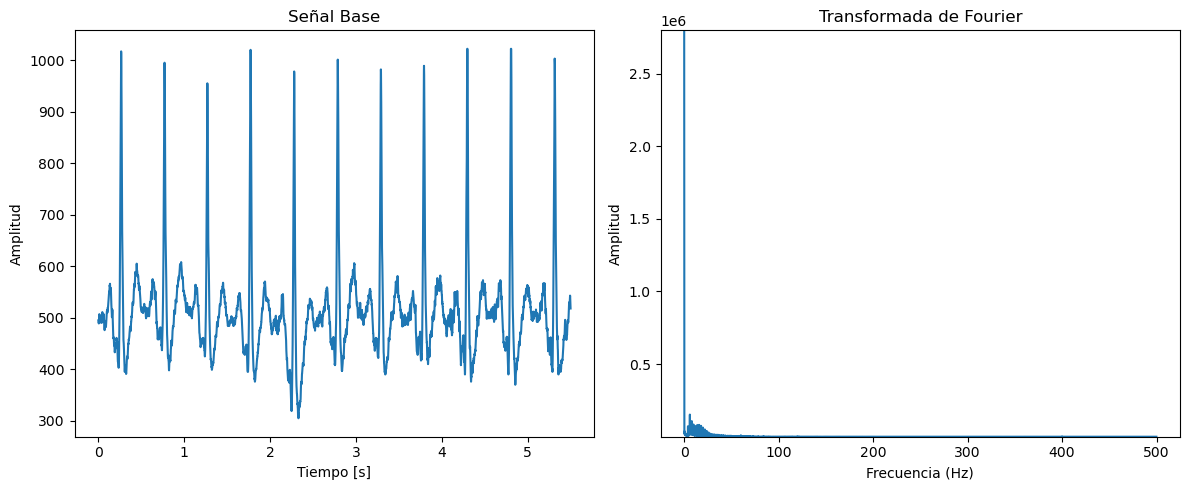

In [57]:
sample, ejercicio_raw = extraer_datos("ejercicio3.txt")
grafica(sample[0:5500], ejercicio_raw[0:5500])

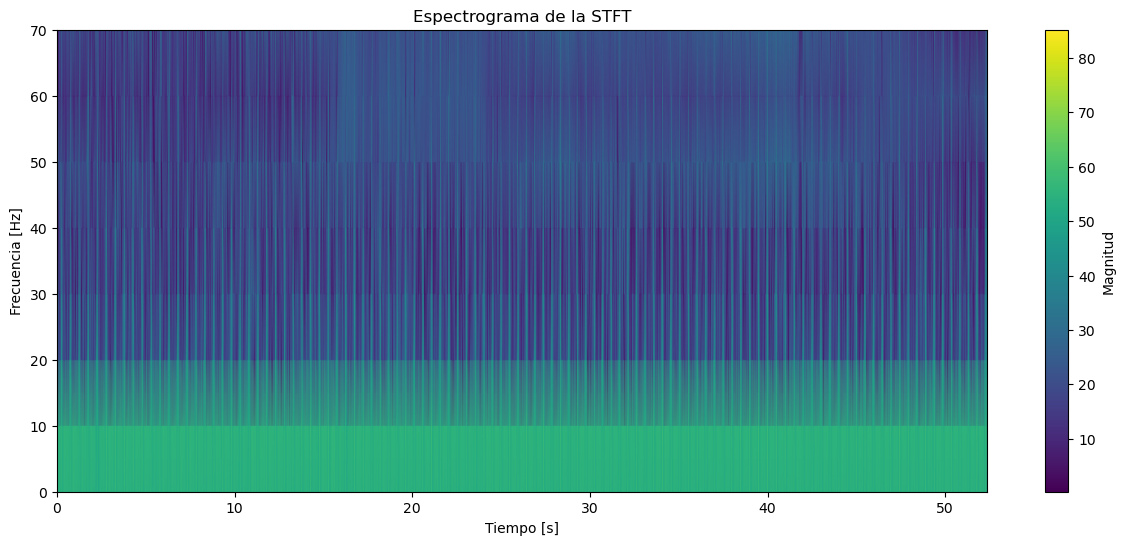

In [58]:
spectrogram(ejercicio_raw, 1000) #Espectrograma de la señal sin filtrar

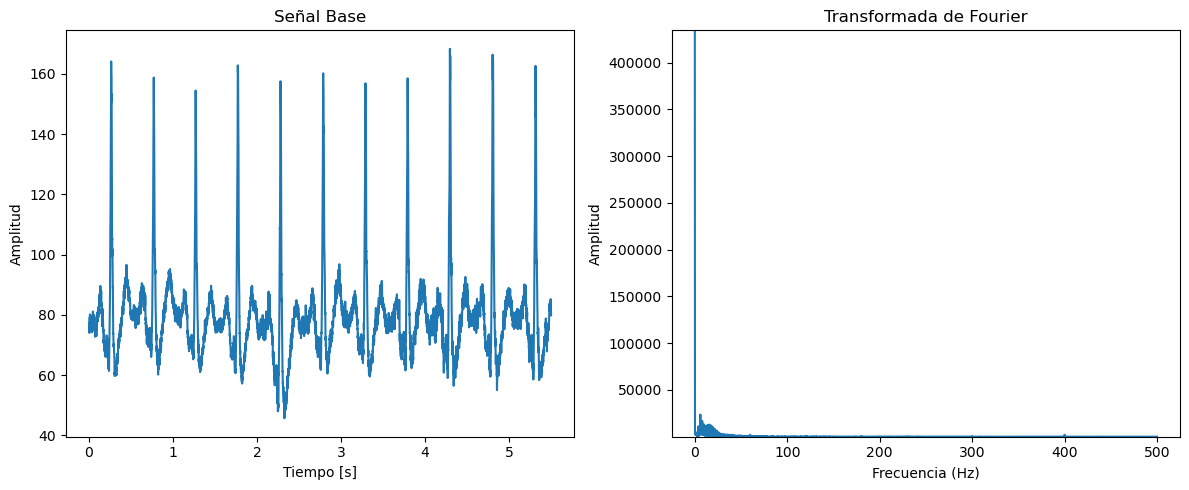

In [59]:
#Para ECG, las señales de interes estan en el rango de 0.05 a 100 Hz
#FILTRO 1: FIR
N = 9
filter1 = firwin(N, 100, pass_zero = "highpass", window = 'blackman', fs=1000) #Se establece una leve atenuacion de 8dB, para suavizar la señal y eliminar parcialmente el posible ruido EMG
filter1 = np.round(filter1, 3) 
y = filtfilt(filter1, np.array(1), ejercicio_raw)
grafica(sample[0:5500], y[0:5500])

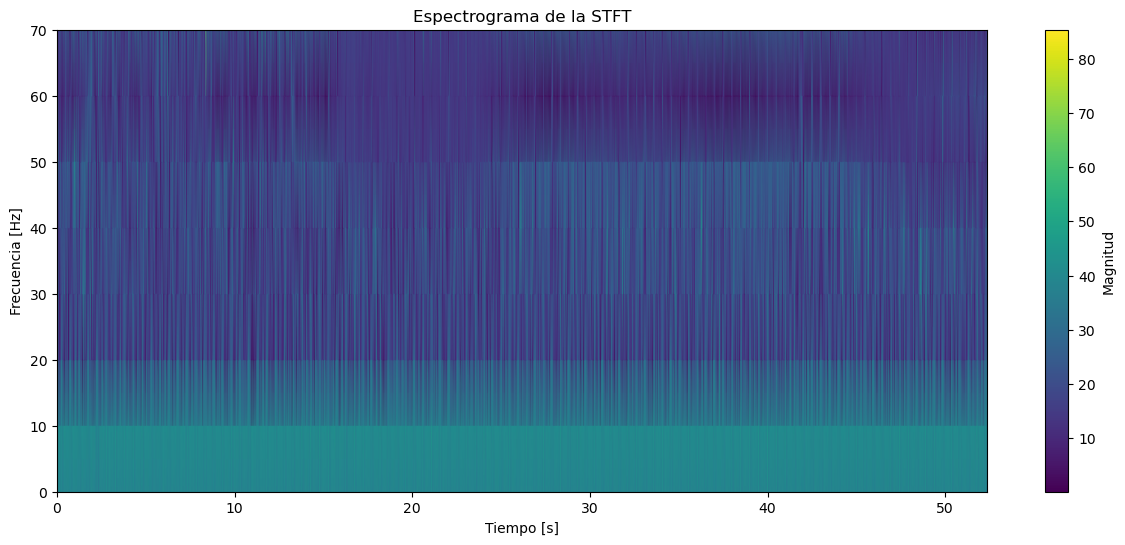

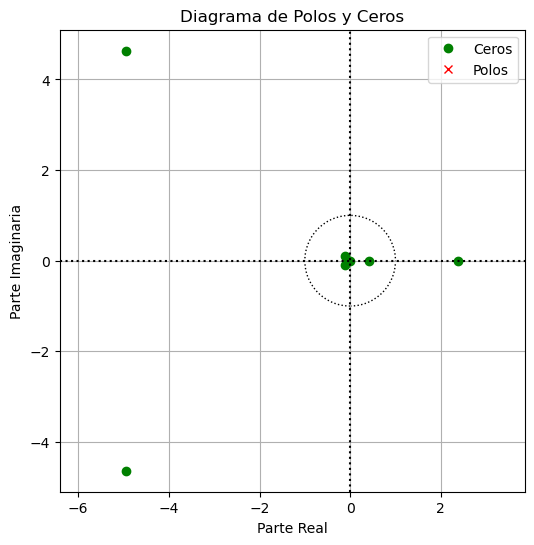

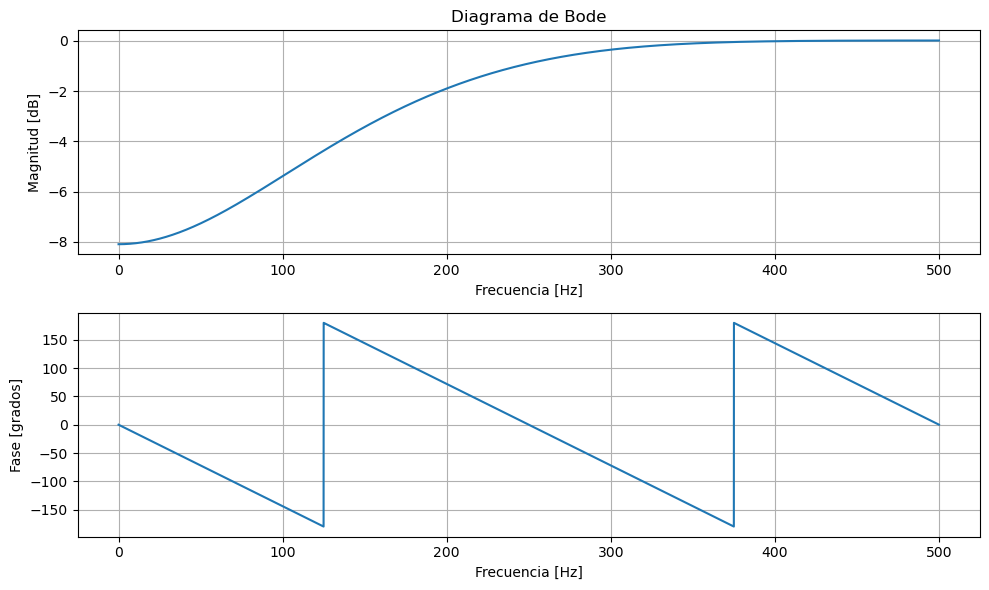

In [60]:
#Como se tiene un FIR, a = 1 y b = filter1
spectrogram(y, 1000)

b = filter1
a = [1]
zplane(b, a)
BODE(b, a, 1000)

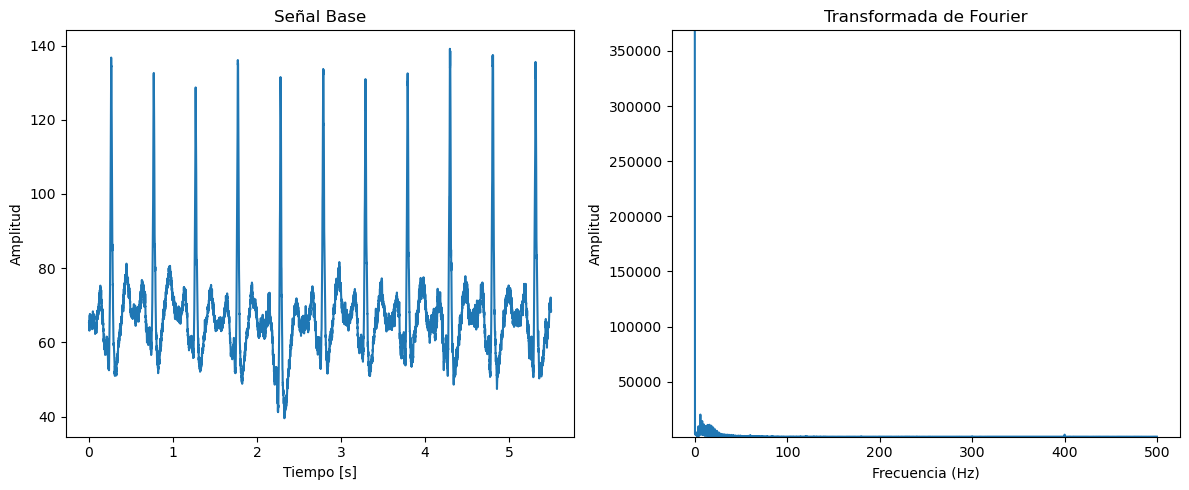

In [61]:
#FILTRO 2: FIR
N = 3
filter2 = firwin(N, 100, pass_zero = 'highpass', window = 'rectangular', fs=1000) 
filter2 = np.round(filter2, 3) 

y = filtfilt(filter2, np.array(1), ejercicio_raw)
grafica(sample[0:5500], y[0:5500])

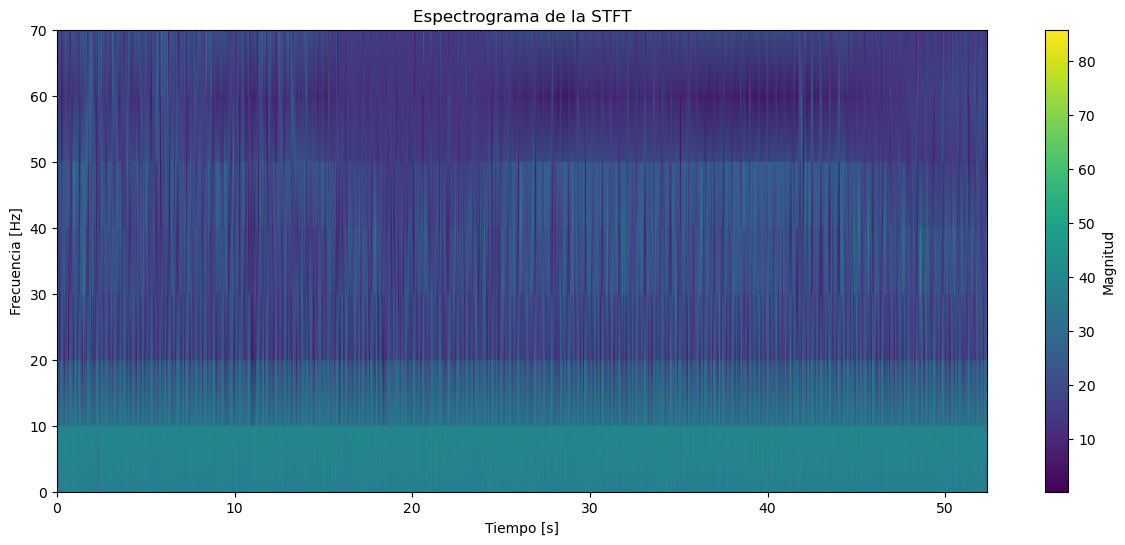

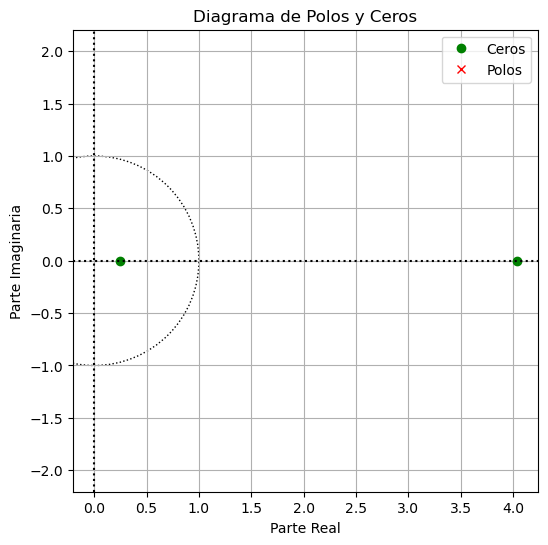

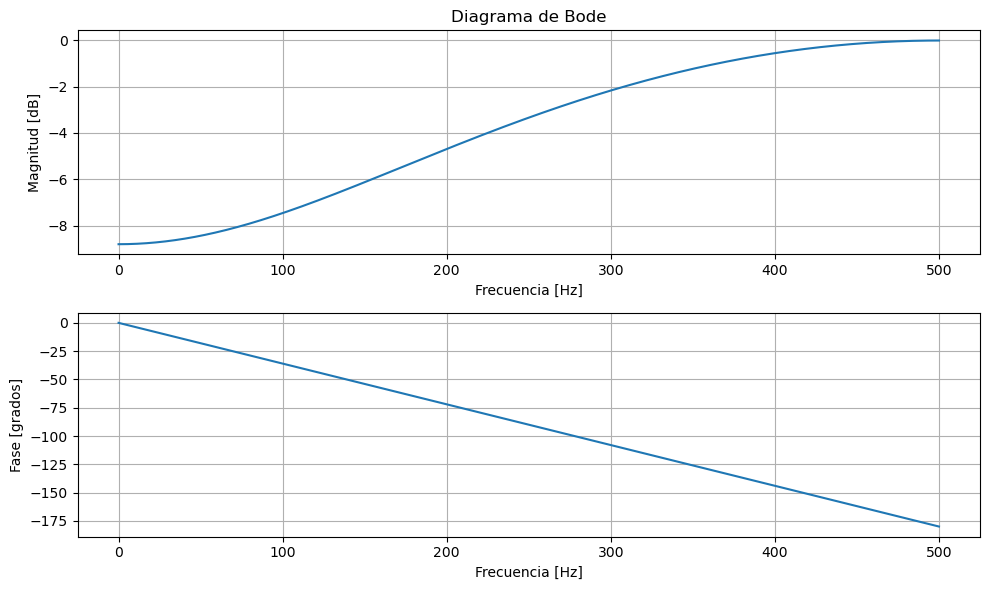

In [62]:
#Como se tiene un FIR, a = 1 y b = filter2
spectrogram(y, 1000)

b = filter2
a = [1]
zplane(b, a)
BODE(b, a, 1000)

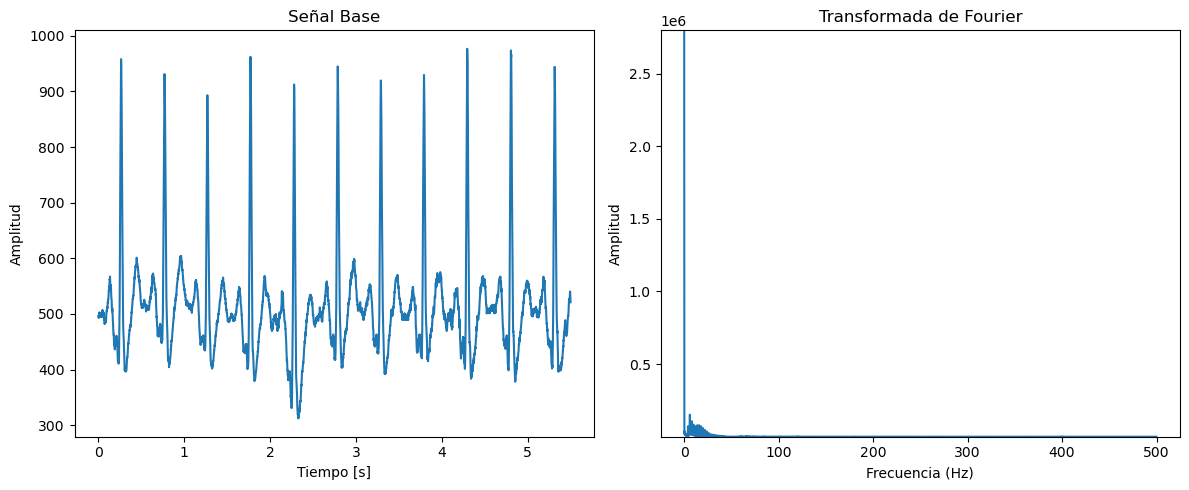

In [63]:
#FILTRO 3: IIR Notch
filtrada, b, a = notch_filter(ejercicio_raw, 1000, 50.0, 2.0)
grafica(sample[0:5500], filtrada[0:5500])

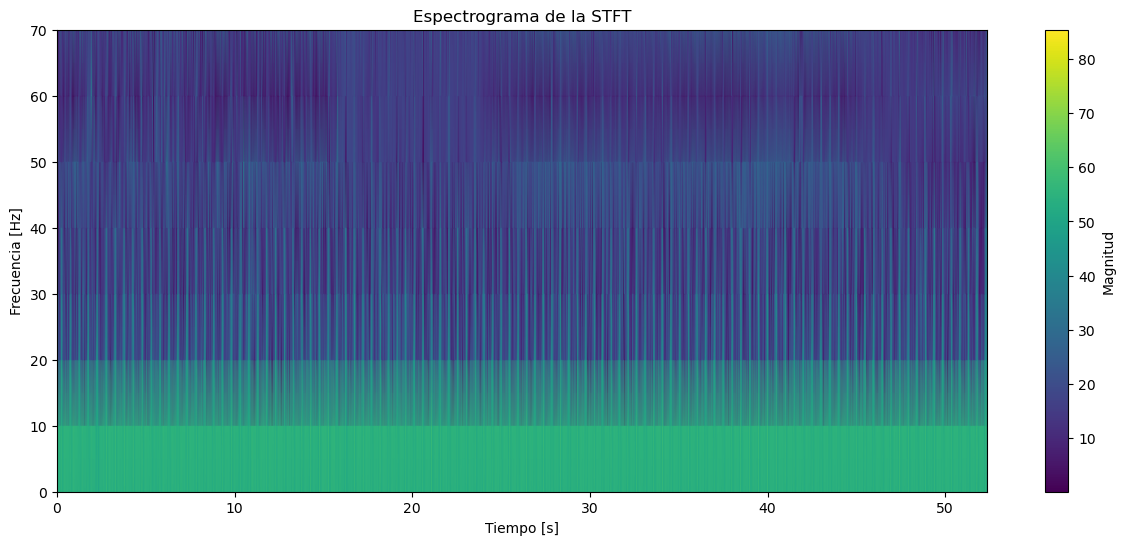

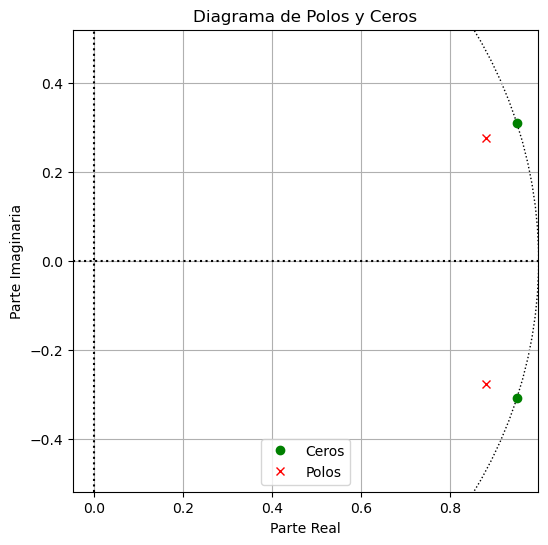

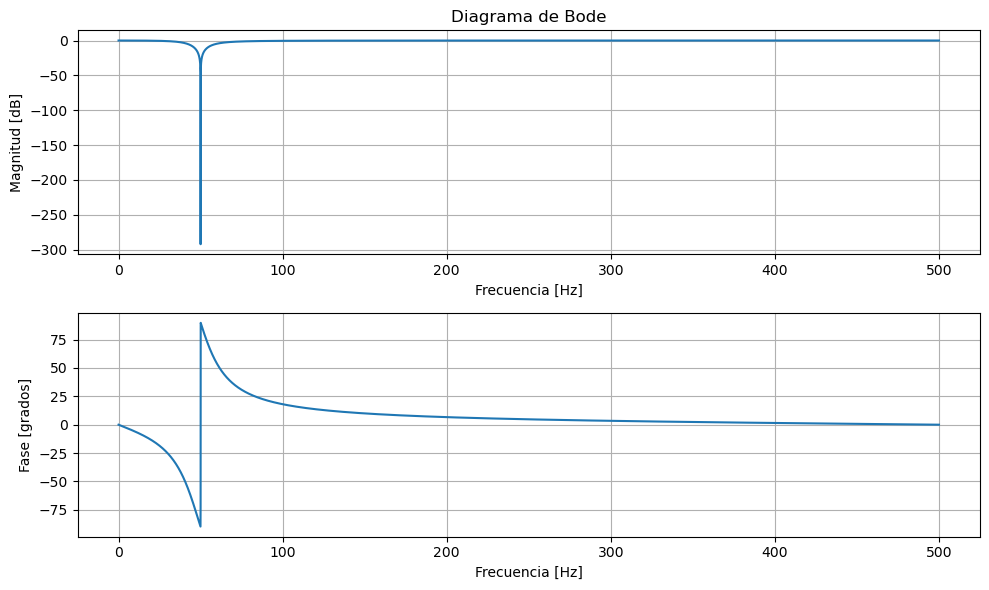

In [64]:
spectrogram(filtrada, 1000)
zplane(b, a)
BODE(b, a, 1000)

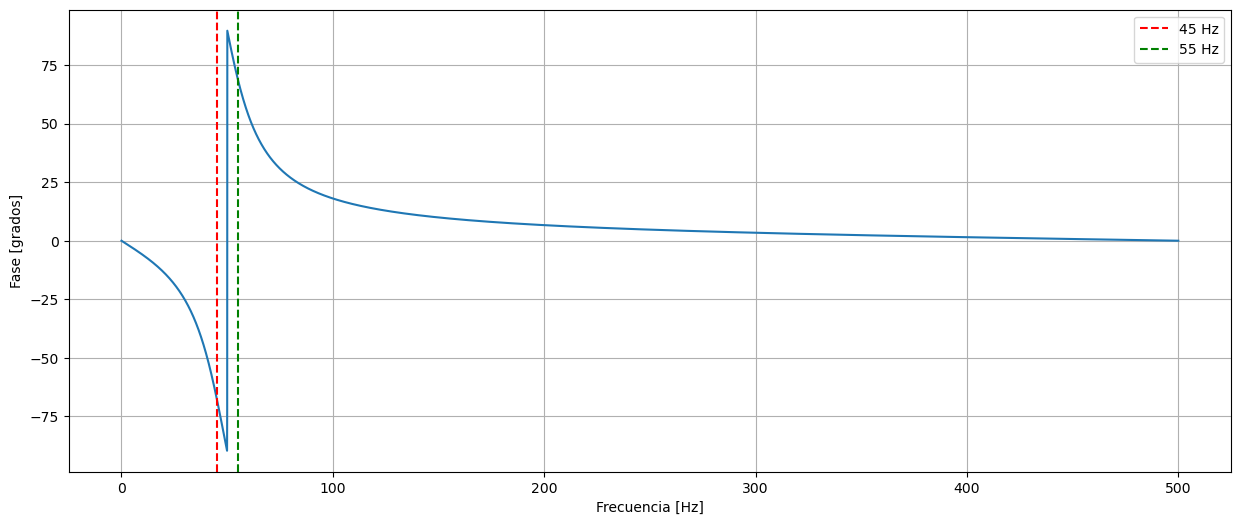

In [65]:
#Veremos si esta particularidad en delay esta en torno a 50Hz
w, H = signal.freqz(b, a, worN=8000)

plt.figure(figsize=(15, 6))
plt.plot(0.5 * 1000 * w / np.pi, np.angle(H) * 180 / np.pi)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [grados]')
plt.grid()
plt.axvline(x=45, color='r', linestyle='--', label='45 Hz')
plt.axvline(x=55, color='g', linestyle='--', label='55 Hz')
plt.legend()
plt.show()